A notebook to create the submission(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    Stacked, SubstitutionOneHot, DNase, Classifier, Regression, RegressionClassifier
from utils import write_submission

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission data

In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
10892,19,11199999,T,G,LDLR,NaN,NaN,NaN,NaN,NaN,0.056,0.455,4.65,4.65
5570,6,396266,C,A,IRF4,NaN,NaN,NaN,NaN,NaN,0.560,0.557,5.27,3.45
5909,6,396427,T,A,IRF4,NaN,NaN,NaN,NaN,NaN,0.019,0.455,3.83,0.10
12994,X,138612630,G,T,F9,NaN,NaN,NaN,NaN,NaN,0.008,0.524,3.15,1.31
6362,6,37775306,G,A,ZFAND3,NaN,NaN,NaN,NaN,NaN,0.004,0.532,3.52,-1.95
6871,6,37775523,A,T,ZFAND3,NaN,NaN,NaN,NaN,NaN,0.983,0.474,5.49,5.49


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    if test:
        stacked = Stacked('test-deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea-test_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11-test_{}_preds_v1.npy')
        crnn = DeepSeaSNP(filename_fmt='crnn_500_200-9-16-test_{}_preds_v1.npy')
    else:
        stacked = Stacked('deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11_{}_preds_v1.npy')
        crnn = DeepSeaSNP(filename_fmt='crnn_500_200-9-16_{}_preds_v1.npy')
    dnase = DNase(test=test)
    conservation = Conservation()
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    return MultiFeatures([deepseadiffs, crnn, dnase, conservation, stacked])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [8]:
# import models, importlib
# importlib.reload(models)
# from models import Regression, Classifier, StackedRegressionClassifier
tuned_params['max_depth'] = 9
regression = Regression(features=train_features, model_kwargs=tuned_params)
classifier = Classifier(features=train_features, model_kwargs=tuned_params)
stacked = RegressionClassifier(regression, classifier)
X_train = stacked.get_features(training)
y_train = stacked.get_response(training)
stacked.fit(X_train, y_train)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Make predictions

In [9]:
X_test = test_features.get_features(submission)
predictions = stacked.predict(X_test, submission.index)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb
13392,0.333691,0.262697,0,0.116912,0.162302,0.403612
5843,0.561887,0.350241,-1,0.405124,-0.099780,0.087872
6756,0.284882,0.310004,0,0.049080,0.093877,0.405115
1565,0.042774,0.826443,1,0.462850,-1.177991,0.130783
7138,0.329210,0.262743,0,0.041262,-0.153164,0.408047
13111,0.297629,0.279992,0,0.059955,0.049239,0.422380


Call which variants are present from the regression predictions

In [10]:
# import models, importlib
# importlib.reload(models)
# from models import call_variants_from_regression
predictions = stacked.make_submission(predictions)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb,Direction,P_Direction,Confidence,SE
796,0.303019,0.345609,0,0.161249,-0.389486,0.351372,0,0.351372,0.161249,0.1
7244,0.238138,0.332178,0,0.096656,-0.089954,0.429685,0,0.429685,0.096656,0.1
532,0.235978,0.456753,1,0.089373,-0.106174,0.307269,1,0.456753,0.089373,0.1
2417,0.598785,0.342373,-1,0.243572,-0.141691,0.058842,-1,0.598785,0.243572,0.1
1957,0.400984,0.283808,-1,0.033889,-0.031431,0.315207,-1,0.400984,0.033889,0.1
6142,0.691721,0.166019,-1,0.055588,-0.033433,0.142260,-1,0.691721,0.055588,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

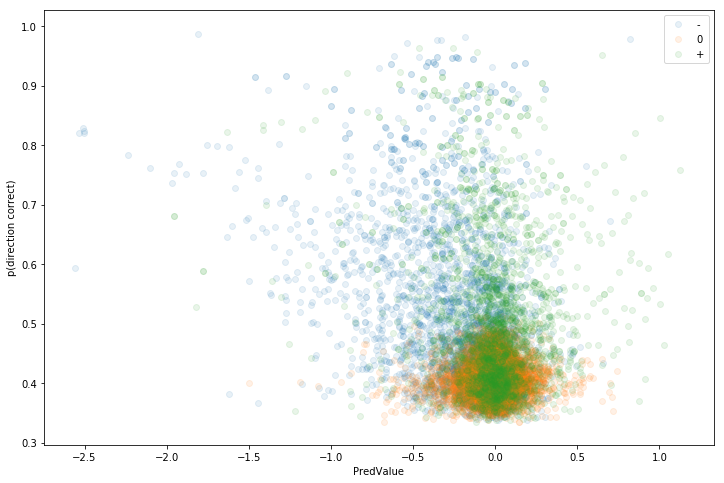

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
alpha = .1
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-', alpha=alpha)
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0', alpha=alpha)
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+', alpha=alpha)
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

## Load confidence standard errors

In [12]:
conf_se = np.load('data/conf-se.npy')
predictions['SE'] = conf_se

### Save predictions

In [13]:
# import utils, importlib
# importlib.reload(utils)
for col in ['Direction', 'P_Direction', 'Confidence', 'SE']:
    submission[col] = predictions[col]
submission['Comments'] = '*'
write_submission(submission, 'data/submission-6.txt')

Writing submission to: data/submission-5.txt
